In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deeplake[enterprise]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.5 MB/s eta 

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

/

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



-

hub://activeloop/nih-chest-xray-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



/

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

77872
8652
25596


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs.sigmoid())
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_ftrs = model.fc.in_features
num_labels = 15

model.fc = nn.Sequential(
  nn.Linear(2048, 1000),
  nn.ReLU(),
  nn.Linear(1000, num_labels),
  nn.Softmax(dim=1)
)

for name, param in model.named_parameters():
  if ('layer3' in name) or ('layer4' in name) or ('fc' in name):
    param.requires_grad = True
  else:
    param.requires_grad = False

for param in model.conv1.parameters():
  param.requires_grad = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

criterion = nn.BCELoss()
optimizer = optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


Running on cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [00:39<00:00, 54.6MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1884
Validation phase completed. Average loss: 0.1837
Micro-averaged ROC AUC: 0.8906055750346101
Macro-averaged ROC AUC: 0.7051424823337386
ROC AUC for label 0: 0.7323168937781374
ROC AUC for label 1: 0.5034435820203893
ROC AUC for label 2: 0.7140111932996751
ROC AUC for label 3: 0.6059249513074468
ROC AUC for label 4: 0.6888299113392441
ROC AUC for label 5: 0.7892617153296142
ROC AUC for label 6: 0.6667931714386829
ROC AUC for label 7: 0.8440909008603165
ROC AUC for label 8: 0.7161148609260232
ROC AUC for label 9: 0.7079885727510888
ROC AUC for label 10: 0.7028253396114599
ROC AUC for label 11: 0.7493916318986307
ROC AUC for label 12: 0.6886390357808851
ROC AUC for label 13: 0.6373323465167772
ROC AUC for label 14: 0.8301731281477088


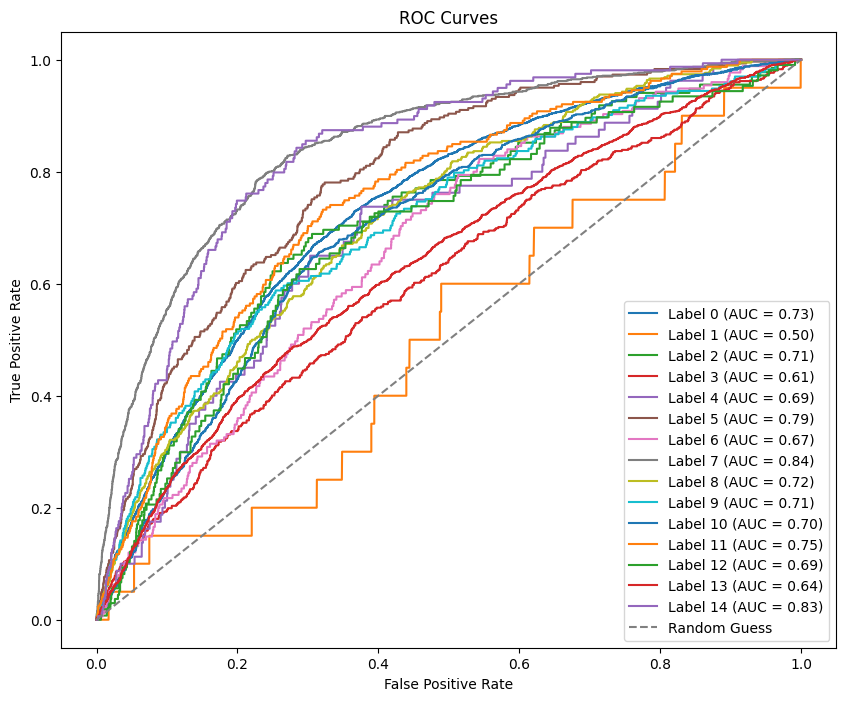

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Unbalanced_ResNet50_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1832
Validation phase completed. Average loss: 0.1843
Micro-averaged ROC AUC: 0.8874069235031934
Macro-averaged ROC AUC: 0.7023321913593137
ROC AUC for label 0: 0.7274010272983853
ROC AUC for label 1: 0.5767811631139944
ROC AUC for label 2: 0.7010210515787597
ROC AUC for label 3: 0.5949001025651651
ROC AUC for label 4: 0.6917033656089595
ROC AUC for label 5: 0.7976986463116797
ROC AUC for label 6: 0.6550235089907144
ROC AUC for label 7: 0.8461065730061801
ROC AUC for label 8: 0.6672380711799004
ROC AUC for label 9: 0.6846943888924857
ROC AUC for label 10: 0.7118745919311633
ROC AUC for label 11: 0.6811738358696718
ROC AUC for label 12: 0.7056370069396215
ROC AUC for label 13: 0.6623356477957351
ROC AUC for label

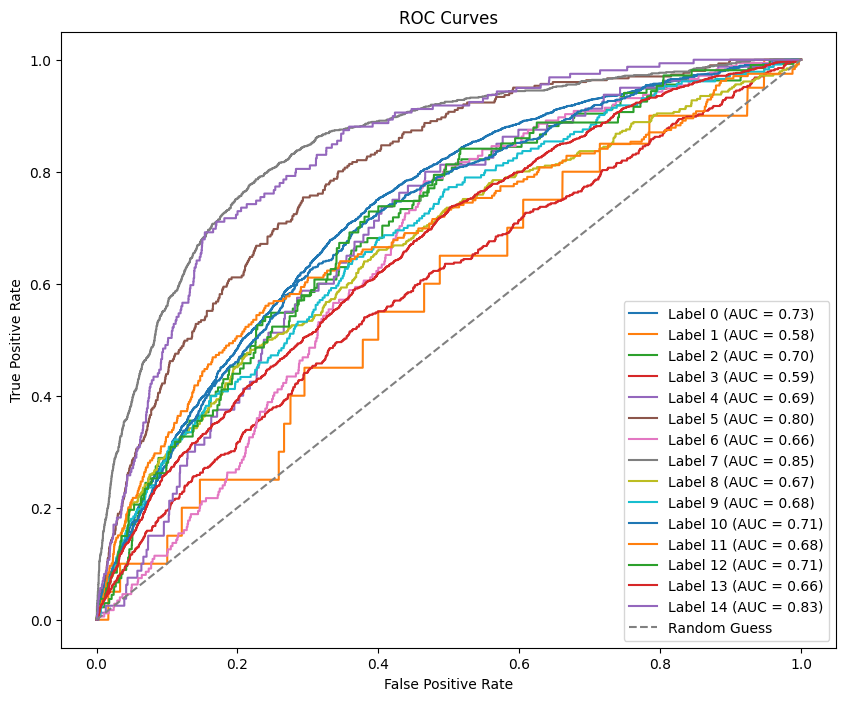

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Unbalanced_ResNet50_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1805
Validation phase completed. Average loss: 0.1777
Micro-averaged ROC AUC: 0.8995641652109796
Macro-averaged ROC AUC: 0.7452321598335264
ROC AUC for label 0: 0.7585746975902727
ROC AUC for label 1: 0.6641624189063948
ROC AUC for label 2: 0.7168482207697895
ROC AUC for label 3: 0.6972892752061663
ROC AUC for label 4: 0.7179268257116191
ROC AUC for label 5: 0.7953683705494519
ROC AUC for label 6: 0.7085009858609009
ROC AUC for label 7: 0.8613344726302614
ROC AUC for label 8: 0.7623754339205862
ROC AUC for label 9: 0.7389735663303982
ROC AUC for label 10: 0.7379191453986275
ROC AUC for label 11: 0.7798821509051295
ROC AUC for label 12: 0.7101502217507095
ROC AUC for label 13: 0.6791928665721982
ROC AUC for label

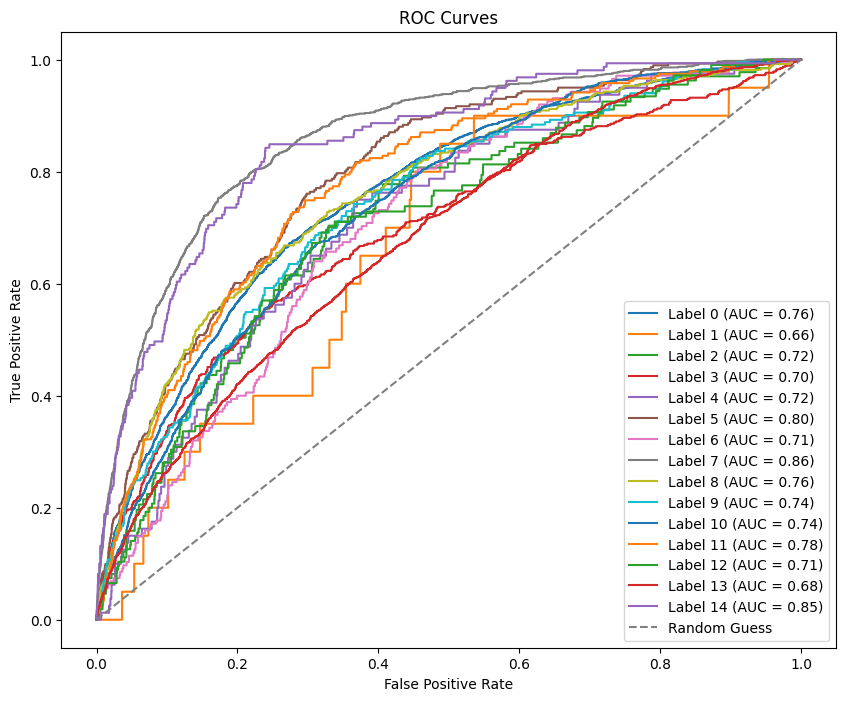

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Unbalanced_ResNet50_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1783
Validation phase completed. Average loss: 0.1806
Micro-averaged ROC AUC: 0.89426161592988
Macro-averaged ROC AUC: 0.7382848522306346
ROC AUC for label 0: 0.7542015713559614
ROC AUC for label 1: 0.770560125115848
ROC AUC for label 2: 0.7094834296548516
ROC AUC for label 3: 0.6778637955327173
ROC AUC for label 4: 0.7065307104526365
ROC AUC for label 5: 0.8036499498140354
ROC AUC for label 6: 0.7152557340029323
ROC AUC for label 7: 0.8565384376908469
ROC AUC for label 8: 0.75705399106647
ROC AUC for label 9: 0.7226993205130231
ROC AUC for label 10: 0.6953375761582609
ROC AUC for label 11: 0.716520606930796
ROC AUC for label 12: 0.6767749626769767
ROC AUC for label 13: 0.6603299946331502
ROC AUC for label 14: 0

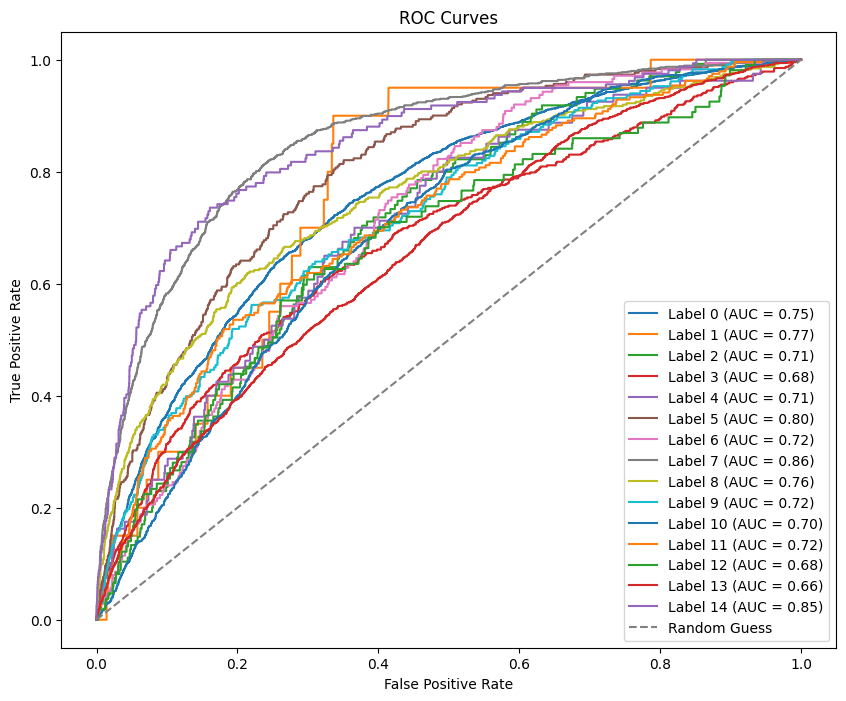

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Unbalanced_ResNet50_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1767
Validation phase completed. Average loss: 0.1772
Micro-averaged ROC AUC: 0.9032652503503059
Macro-averaged ROC AUC: 0.7618033979125438
ROC AUC for label 0: 0.7526148465364632
ROC AUC for label 1: 0.7378417516218722
ROC AUC for label 2: 0.7599972168951856
ROC AUC for label 3: 0.7137921656790022
ROC AUC for label 4: 0.6949946045263649
ROC AUC for label 5: 0.8043387884793871
ROC AUC for label 6: 0.7785230624041526
ROC AUC for label 7: 0.8632803905032128
ROC AUC for label 8: 0.8152711212294824
ROC AUC for label 9: 0.7489741933609193
ROC AUC for label 10: 0.7308218493051737
ROC AUC for label 11: 0.7796618303910018
ROC AUC for label 12: 0.7154930193642235
ROC AUC for label 13: 0.6738130943059298
ROC AUC for label

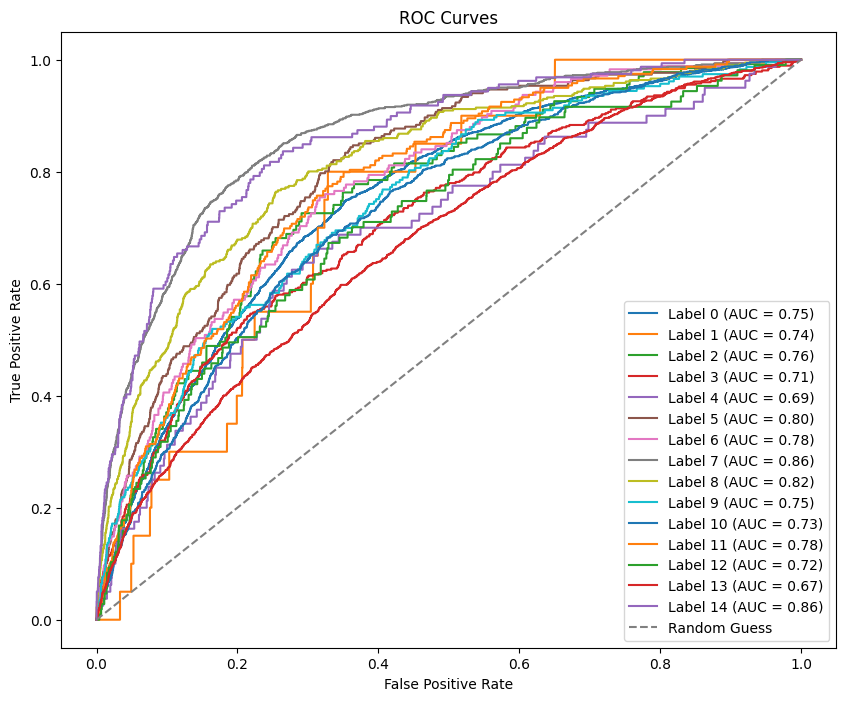

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Unbalanced_ResNet50_checkpoint_epoch_5.pt


In [ ]:
num_epochs = 5
model_name = "SSN_BCE_Unbalanced_ResNet50"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_BCE_Unbalanced_ResNet50.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)